Computation of an accelerated MCEq parametrization
-----------------------------------------------------

In [1]:
import os, sys
my_mceq_location = '/home/jp/projects/mceq/MCEq_jp'
my_hpmceq_location = '/home/jp/projects/mceq/hp-IC-MCEq'
os.chdir(my_mceq_location)

In [2]:
#basic imports and jupyter setup
%load_ext autoreload
%matplotlib inline
%autoreload 2
import os
import matplotlib.pyplot as plt
import numpy as np
import sys
import scipy
from copy import deepcopy
#path to MCEq (it makes sense to put it in the same base directory as this project)
sys.path.append('/home/jp/projects/mceq/hp-IC-MCEq/references')
sys.path.append('/home/jp/projects/mceq/hp-IC-MCEq/calculations')

#import solver related modules
import MCEq
reload(MCEq)
from MCEq.core import MCEqRun
from mceq_config import config, mceq_config_without
#import primary model choices
import CRFluxModels as pm


Create an instance of an MCEqRun class. Most of its areguments are contained in the `config` dictionary from the `mceq_config` module. Look into or edit `mceq_config.py`.

If the initialization succeeds it will print out some information according to the debug level. 

In [3]:
mceq_run = MCEqRun(
#provide the string of the interaction model
interaction_model='SIBYLL2.3c',
#primary cosmic ray flux model
#support a tuple (primary model class (not instance!), arguments)
primary_model = (pm.GlobalSplineFitBeta, None),
# Zenith angle in degrees. 0=vertical, 90=horizontal
theta_deg=0.0,
#density model
density_model=('CORSIKA', ('BK_USStd', None)),
#expand the rest of the options from mceq_config.py
**mceq_config_without(['density_model'])
)

AttributeError: 'module' object has no attribute 'GlobalSplineFitBeta'

__________

If everything succeeds than the last message should be something like

`MCEqRun::set_primary_model():  HillasGaisser2012 H3a`.

Definition of the Barr phase-space splitting (Figure 2 and 3 of their paper)
--------------------------------------------------------------------------------

In [3]:
# Global Barr parameter table 
# format (x_min, x_max, E_min, E_max) | x is x_lab= E_pi/E, E projectile-air interaction energy
barr = {
    'a': [(0.0, 0.5, 0.00, 8.0)],
    'b1': [(0.5, 1.0, 0.00, 8.0)],
    'b2': [(0.6, 1.0, 8.00, 15.0)],
    'c': [(0.2, 0.6, 8.00, 15.0)],
    'd1': [(0.0, 0.2, 8.00, 15.0)],
    'd2': [(0.0, 0.1, 15.0, 30.0)],
    'd3': [(0.1, 0.2, 15.0, 30.0)],
    'e': [(0.2, 0.6, 15.0, 30.0)],
    'f': [(0.6, 1.0, 15.0, 30.0)],
    'g': [(0.0, 0.1, 30.0, 1e11)],
    'h1': [(0.1, 1.0, 30.0, 500.)],
    'h2': [(0.1, 1.0, 500.0, 1e11)],
    'i': [(0.1, 1.0, 500.0, 1e11)],
    'w1': [(0.0, 1.0, 0.00, 8.0)],
    'w2': [(0.0, 1.0, 8.00, 15.0)],
    'w3': [(0.0, 0.1, 15.0, 30.0)],
    'w4': [(0.1, 0.2, 15.0, 30.0)],
    'w5': [(0.0, 0.1, 30.0, 500.)],
    'w6': [(0.0, 0.1, 500., 1e11)],
    'x': [(0.2, 1.0, 15.0, 30.0)],
    'y1': [(0.1, 1.0, 30.0, 500.)],
    'y2': [(0.1, 1.0, 500., 1e11)],
    'z': [(0.1, 1.0, 500., 1e11)],
    'ch_a': [(0.0, 0.1, 0., 1e11)],
    'ch_b': [(0.1, 1.0, 0., 1e11)],
    'ch_e': [(0.1, 1.0, 800., 1e11)],
}


def barr_unc(xmat, egrid, pname, value):
    """Implementation of hadronic uncertainties as in Barr et al. PRD 74 094009 (2006)

    The names of parameters are explained in Fig. 2 and Fig. 3 in the paper."""


    # Energy dependence
    u = lambda E, val, ethr, maxerr, expected_err: val*min(
        maxerr/expected_err,
        0.122/expected_err*np.log10(E / ethr)) if E > ethr else 0.

    modmat = np.ones_like(xmat)
    modmat[np.tril_indices(xmat.shape[0], -1)] = 0.

    for minx, maxx, mine, maxe in barr[pname]:
        eidcs = np.where((mine < egrid) & (egrid <= maxe))[0]
        for eidx in eidcs:
            xsel = np.where((xmat[:eidx + 1, eidx] >= minx) &
                            (xmat[:eidx + 1, eidx] <= maxx))[0]
            if not np.any(xsel):
                continue
            if pname in ['i', 'z']:
                modmat[xsel, eidx] += u(egrid[eidx], value, 500., 0.5, 0.122)
            elif pname in ['ch_e']:
                modmat[xsel, eidx] += u(egrid[eidx], value, 800., 0.3, 0.25)
            else:
                modmat[xsel, eidx] += value

    return modmat

Compare linear extrapolation to properly computed variations
---------------------------------------------------------------

In [28]:
# Compute central flux
# Reset all modifications
mceq_run.set_theta_deg(60.) # is cos_theta=0.5
mceq_run.unset_mod_pprod()
# Print the current state of particle production (pprod) modifications
mceq_run.y.print_mod_pprod()
# Run solver
mceq_run.solve()
# Store flux 
numu_flux_central = mceq_run.get_solution('total_numu',0) #+ mceq_run.get_solution('total_antinumu',0)
mupl_flux_central = mceq_run.get_solution('total_mu+',0)
mu_ratio_central = mceq_run.get_solution('total_mu+',0)/mceq_run.get_solution('total_mu-',0)

In [25]:
# Modify pion production for Barr variable 'h' by +10%
mceq_run.unset_mod_pprod(dont_fill=True)
# Modify proton-air -> pi+ (211) for 'h1', 'h2' patches simultaneously
mceq_run.set_mod_pprod(2212,211,barr_unc,('h1',0.1))
mceq_run.set_mod_pprod(2212,211,barr_unc,('h2',0.1))
# Populate the modifications to the matrices by re-filling the interaction matrix
mceq_run._init_default_matrices(skip_D_matrix=True)
# Print the changes
print "\n \n This is the printout from the print_mod_pprod routine"
mceq_run.y.print_mod_pprod()
print "\n \n"
# Run solver
mceq_run.solve()
# Save flux
numu_flux_mod_pions = mceq_run.get_solution('total_numu',0)
mupl_flux_mod_pions = mceq_run.get_solution('total_mu+',0)
mu_ratio_mod_pions = mceq_run.get_solution('total_mu+',0)/mceq_run.get_solution('total_mu-',0)


 
 This is the printout from the print_mod_pprod routine
0: 2112 -> -211, func: isospin, arg: ('h2', 0.1)
1: 2112 -> -211, func: isospin, arg: ('h1', 0.1)
1: 2212 -> 211, func: barr_unc, arg: ('h2', 0.1)
2: 2212 -> 211, func: barr_unc, arg: ('h1', 0.1)

 



Load the precomputed flux interpolations from file
----------------------------------------------------

In [6]:
import cPickle as pickle
from bz2 import BZ2File

store = pickle.load(BZ2File('../MCEqApps/hp_MCEq_superfast_jacobians_20171101_1e7_GSF_sib23c.ppd.bz2')) 

In [7]:
# Truncate energy grid as used for interpolation
tr = np.where(mceq_run.e_grid < 1e5)
etr = mceq_run.e_grid[tr]

In [8]:
# This is the only thing needed
def get_flux(nuspec, E, cos_theta, barr_par, barr_v):
    st_ids = {'mupl' : 0,
              'mumi' : 2,
              'numu' : 4,
              'anumu': 6,
              'nue'  : 8,
              'anue' : 10}
    st_id = st_ids[nuspec]
    flux_spl, d_spl = store[barr_par][st_id:st_id + 2]
    
    return flux_spl(cos_theta, np.log(E)) + barr_v * d_spl(cos_theta, np.log(E))

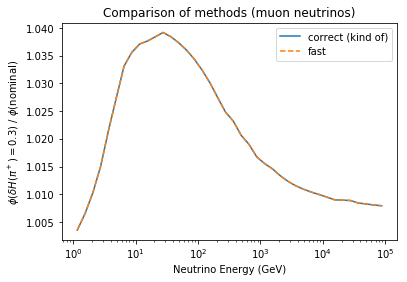

In [27]:
plt.title('Comparison of methods (muon neutrinos)')
plt.semilogx(etr, numu_flux_mod_pions[tr]/numu_flux_central[tr], label='correct (kind of)')
plt.semilogx(etr, get_flux('numu', etr, 0.5, 'h+', 0.1)[0]/get_flux('numu', etr, 0.5, 'h+', 0.0)[0],
             label='fast', ls='--')
plt.ylabel(r'$\phi(\delta H(\pi^+) = 0.3)\ /\ \phi({\rm nominal})$ ')
plt.xlabel('Neutrino Energy (GeV)')
plt.legend()

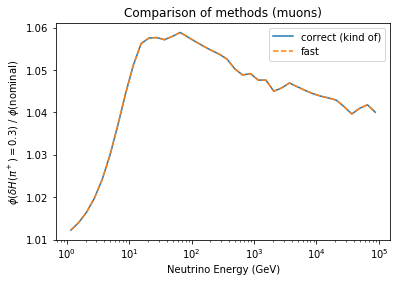

In [26]:
plt.title('Comparison of methods (muons)')
plt.semilogx(etr, mupl_flux_mod_pions[tr]/mupl_flux_central[tr], label='correct (kind of)')
plt.semilogx(etr, get_flux('mupl', etr, 0.5, 'h+', 0.1)[0]/get_flux('mupl', etr, 0.5, 'h+', 0.0)[0],
             label='fast', ls='--')
plt.ylabel(r'$\phi(\delta H(\pi^+) = 0.3)\ /\ \phi({\rm nominal})$ ')
plt.xlabel('Neutrino Energy (GeV)')
plt.legend()

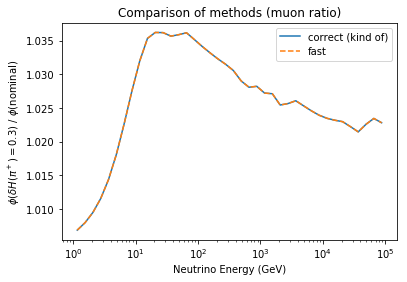

In [31]:
plt.title('Comparison of methods (muon ratio)')
plt.semilogx(etr, mu_ratio_mod_pions[tr]/mu_ratio_central[tr], label='correct (kind of)')
plt.semilogx(etr, 
    (get_flux('mupl', etr, 0.5, 'h+', 0.1)[0]/get_flux('mumi', etr, 0.5, 'h+', 0.1)[0]) /
    (get_flux('mupl', etr, 0.5, 'h+', 0.0)[0]/get_flux('mumi', etr, 0.5, 'h+', 0.0)[0]),
     label='fast', ls='--')
plt.ylabel(r'$\phi(\delta H(\pi^+) = 0.3)\ /\ \phi({\rm nominal})$ ')
plt.xlabel('Neutrino Energy (GeV)')
plt.legend()

In [10]:
%timeit get_flux('anumu', etr, [0.1, 0.3, 0.5], 'h-', 0.3)

The slowest run took 11.84 times longer than the fastest. This could mean that an intermediate result is being cached.
10000 loops, best of 3: 19 µs per loop
